# 📊 Model Evaluation Notebook – Fire Detection Project

This notebook evaluates the performance of any trained fire classification model on the **D-Fire test set**, which is held constant to ensure fair comparisons across training strategies.

It supports evaluation of:
- ✅ Real-only models (e.g. `resnet_real_100.pt`)
- ✅ Synthetic-only models (e.g. `resnet_synthetic_100.pt`)
- ✅ Mixed synthetic-real models (e.g. `resnet_mixed_25syn_75real.pt`)
- 🔄 Fine-tuned variants and alternative architectures (if applicable)

Evaluation includes:
- Computing core metrics: **Accuracy**, **Precision**, **Recall**, and **F1-score**
- Generating a **confusion matrix** and **classification report**
- Plotting a **ROC curve** (if probability scores are available)
- Optionally saving results to `/figures/` and `/results/` for report use

---

## ⚙️ Usage Instructions

1. Set the `model_filename` variable at the top of the notebook (e.g. `resnet_synthetic_100.pt`)
2. Ensure the model is saved in `/models/` and test data is unchanged (D-Fire only)
3. Run the notebook from top to bottom to evaluate the model and generate visual outputs

---


## 📦 Notebook Setup: Mount Drive & Clone GitHub Repo

This cell ensures the notebook is reproducible in any new Colab session by:

- Mounting your Google Drive (to access datasets, secrets, and checkpoints)
- Loading your GitHub token from Drive
- Cloning the fire-detection-dissertation repository
- Navigating into the correct folder
- Setting Git identity for future commits

⚠️ **Note:** This cell must be run every time you open this notebook in a new Colab session.


In [1]:
# 🔧 Minimal Colab setup for any working notebook

# 1. Mount Google Drive
import os
from google.colab import drive
if not os.path.ismount("/content/drive"):
    drive.mount("/content/drive")

# 2. Load GitHub token securely from Drive
token_path = "/content/drive/MyDrive/fire-detection-dissertation/secrets/github_token.txt"
with open(token_path, "r") as f:
    token = f.read().strip()

# 3. Clone the GitHub repo (force fresh clone for safety)
username = "Misharasapu"
repo = "fire-detection-dissertation"
clone_url = f"https://{token}@github.com/{username}/{repo}.git"
repo_path = f"/content/{repo}"

# Optional: Remove old clone (safe to rerun)
!rm -rf {repo_path}

# Clone fresh and move into the repo
%cd /content
!git clone {clone_url}
%cd {repo}

# 4. Set Git identity (required in Colab sessions)
!git config --global user.name "Misharasapu"
!git config --global user.email "misharasapu@gmail.com"


Mounted at /content/drive
/content
Cloning into 'fire-detection-dissertation'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (60/60), done.
remote: Total 76 (delta 33), reused 53 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (76/76), 2.52 MiB | 7.77 MiB/s, done.
Resolving deltas: 100% (33/33), done.
/content/fire-detection-dissertation


## 🧪 Step 1: Load the D-Fire Test Dataset

This step loads the hold-out test set from the real **D-Fire** dataset, which is used as the standard benchmark for evaluating all models — regardless of whether they were trained on real, synthetic, or mixed data.

We use the `FireClassificationDataset` class to pair each image with its corresponding YOLO-format label. The images are preprocessed using the same transforms applied during training: resizing to 224×224 and converting to PyTorch tensors.

Maintaining consistent input processing and label logic ensures that model predictions can be fairly evaluated using classification metrics.


In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.fire_classification_dataset import FireClassificationDataset

# 🔧 Evaluation is always done on real D-Fire test set
test_image_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/test/images"
test_label_dir = "/content/drive/MyDrive/fire-detection-dissertation/data/raw/real/D-Fire/test/labels"

# ✅ Define preprocessing transforms (same as used in training)
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# ✅ Load test dataset and create DataLoader
test_dataset = FireClassificationDataset(
    image_dir=test_image_dir,
    label_dir=test_label_dir,
    transform=test_transforms
)

test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

print(f"✅ Loaded D-Fire test set with {len(test_dataset)} images.")


✅ Loaded D-Fire test set with 4306 images.


## 🧠 Step 2: Load the Trained ResNet-50 Model

In this step, we load a trained **ResNet-50** model from a saved checkpoint stored in the `/models/` directory. This model may have been trained on real, synthetic, or mixed datasets, but the final architecture is standardised for binary classification (fire vs. no fire).

We create a fresh ResNet-50 instance and replace the final fully connected (FC) layer to output 2 logits. The checkpoint weights are then loaded, and the model is moved to the appropriate device (GPU or CPU) for evaluation.

To evaluate a different model, simply update the `model_filename` variable in the code cell below.


In [3]:
import torch
import torch.nn as nn
import torchvision.models as models

# Select device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"🔌 Using device: {device}")

# 🔧 Set the model filename here (change this to evaluate a different model)
model_filename = "resnet_mixed_25syn_75real.pt"
checkpoint_path = f"/content/drive/MyDrive/fire-detection-dissertation/models/{model_filename}"

# Load a fresh ResNet-50 model
model = models.resnet50(pretrained=False)

# Replace the final FC layer for binary classification (fire vs no fire)
model.fc = nn.Linear(model.fc.in_features, 2)

# Load checkpoint weights into the model
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# Move to device and set to evaluation mode
model = model.to(device)
model.eval()

print(f"✅ Loaded model: {model_filename} and ready for evaluation.")


🔌 Using device: cpu


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✅ Loaded model: resnet_mixed_25syn_75real.pt and ready for evaluation.


## 📈 Step 3: Evaluate Model on Hold-Out Test Set

In this step, we use the trained ResNet-50 model to generate predictions on the unseen **D-Fire test set**. These predictions are compared against ground-truth labels to compute core classification metrics:

- Accuracy
- Precision
- Recall
- F1 Score

We use the `calculate_metrics()` helper function (defined in `utils/metrics.py`) to ensure consistent metric computation across the project. Evaluation is run with gradient computation disabled, and the model remains in `eval()` mode to avoid any parameter updates.


In [7]:
from utils.metrics import calculate_metrics
from tqdm import tqdm
import os

# Store predictions and ground truth labels
all_preds = []
all_labels = []

print(f"\n🔍 Starting evaluation for: {model_filename}")
print("⏳ Running inference on test set...")

# Disable gradient computation during inference
with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="🧪 Evaluating", unit="batch"):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)

        # Take the class with the highest score
        preds = torch.argmax(outputs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to tensors for metric computation
y_true_tensor = torch.tensor(all_labels)
y_pred_tensor = torch.tensor(all_preds)

# Calculate evaluation metrics
metrics = calculate_metrics(y_true_tensor, y_pred_tensor)

# Print results
print(f"\n📊 Evaluation Results for: {model_filename}")
print(f"Accuracy : {metrics['accuracy']:.4f}")
print(f"Precision: {metrics['precision']:.4f}")
print(f"Recall   : {metrics['recall']:.4f}")
print(f"F1 Score : {metrics['f1']:.4f}")

# ✅ Save results to text file
results_dir = "/content/drive/MyDrive/fire-detection-dissertation/results/metrics/"
os.makedirs(results_dir, exist_ok=True)

results_str = (
    f"📊 Evaluation Results for Model: {model_filename}\n"
    "---------------------------------------------\n"
    f"Accuracy : {metrics['accuracy']:.4f}\n"
    f"Precision: {metrics['precision']:.4f}\n"
    f"Recall   : {metrics['recall']:.4f}\n"
    f"F1 Score : {metrics['f1']:.4f}\n"
)

metrics_file = os.path.join(results_dir, f"{model_filename.replace('.pt', '')}.txt")
with open(metrics_file, "w") as f:
    f.write(results_str)

print(f"\n✅ Metrics saved to: {metrics_file}")



🔍 Starting evaluation for: resnet_mixed_25syn_75real.pt
⏳ Running inference on test set...


🧪 Evaluating: 100%|██████████| 135/135 [21:07<00:00,  9.39s/batch]



📊 Evaluation Results for: resnet_mixed_25syn_75real.pt
Accuracy : 0.9190
Precision: 0.8704
Recall   : 0.8072
F1 Score : 0.8376

✅ Metrics saved to: /content/drive/MyDrive/fire-detection-dissertation/results/metrics/resnet_mixed_25syn_75real.txt


## 🧮 Step 4: Confusion Matrix and Classification Report

In this step, we visualise the model’s predictions using a **confusion matrix**, which shows the distribution of correct and incorrect classifications across the two classes (fire vs. no fire).

We also generate a **classification report** using `scikit-learn`, which provides:
- Precision, Recall, and F1-score **per class**
- Support (i.e. number of samples per class in the test set)

These tools help interpret how well the model handles each class and are especially useful for understanding performance on imbalanced or noisy datasets.


✅ Confusion matrix saved to: /content/drive/MyDrive/fire-detection-dissertation/figures/confusion_matrices/resnet_mixed_25syn_75real.png


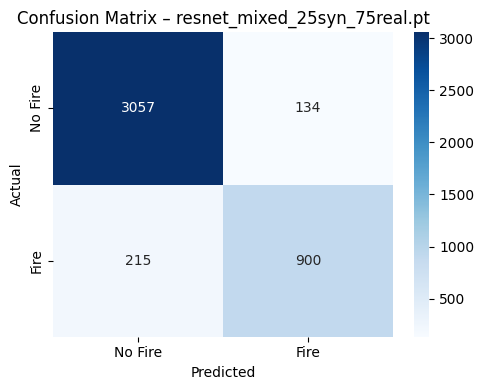


📝 Classification Report:
              precision    recall  f1-score   support

     No Fire       0.93      0.96      0.95      3191
        Fire       0.87      0.81      0.84      1115

    accuracy                           0.92      4306
   macro avg       0.90      0.88      0.89      4306
weighted avg       0.92      0.92      0.92      4306



In [8]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Ensure y_true and y_pred are numpy arrays
y_true = y_true_tensor.numpy()
y_pred = y_pred_tensor.numpy()

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["No Fire", "Fire"],
            yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix – {model_filename}")
plt.tight_layout()

# Save confusion matrix to /figures/confusion_matrices/
cm_dir = "/content/drive/MyDrive/fire-detection-dissertation/figures/confusion_matrices/"
os.makedirs(cm_dir, exist_ok=True)
cm_path = os.path.join(cm_dir, f"{model_filename.replace('.pt', '')}.png")
plt.savefig(cm_path)
print(f"✅ Confusion matrix saved to: {cm_path}")

plt.show()

# Print classification report
print("\n📝 Classification Report:")
print(classification_report(y_true, y_pred, target_names=["No Fire", "Fire"]))


## 📉 Step 5: ROC Curve and AUC Score

In this step, we evaluate the model's ability to distinguish between fire and no-fire images by plotting the **Receiver Operating Characteristic (ROC) curve**.

- The ROC curve illustrates the trade-off between **True Positive Rate** (Recall) and **False Positive Rate** at various classification thresholds.
- The **AUC score** (Area Under Curve) quantifies this curve into a single value:  
  - AUC = 1.0 → Perfect separation  
  - AUC = 0.5 → Random guessing

We use the **softmax probabilities of the "Fire" class** (class 1) to compute both the ROC and AUC. The resulting plot and AUC score are saved alongside the other evaluation results.


✅ ROC curve saved to: /content/drive/MyDrive/fire-detection-dissertation/figures/roc_curves/resnet_mixed_25syn_75real.png


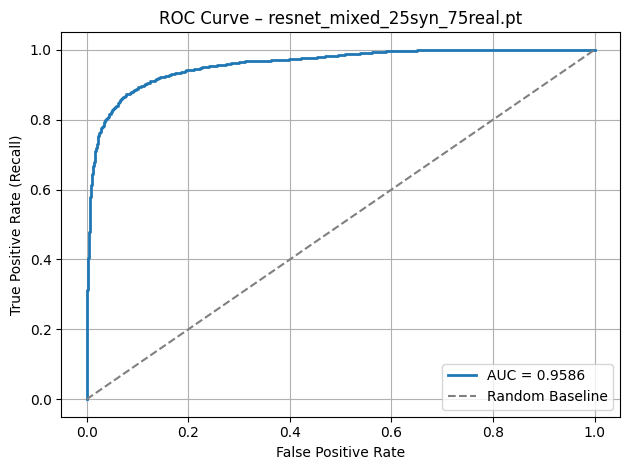

✅ AUC score appended to: /content/drive/MyDrive/fire-detection-dissertation/results/metrics/resnet_mixed_25syn_75real.txt


In [9]:
from sklearn.metrics import roc_curve, roc_auc_score
from torch.nn.functional import softmax
import matplotlib.pyplot as plt
import os


# Use the same labels from evaluation step
y_true = y_true_tensor.numpy()

# Collect softmax probabilities for "Fire" (class 1)
y_probs = []

model.eval()
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        probs = softmax(outputs, dim=1)[:, 1]  # Probability of class 1
        y_probs.extend(probs.cpu().numpy())

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_probs)
auc_score = roc_auc_score(y_true, y_probs)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", linewidth=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random Baseline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title(f"ROC Curve – {model_filename}")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()

# Save ROC curve to /figures/roc_curves/
roc_dir = "/content/drive/MyDrive/fire-detection-dissertation/figures/roc_curves/"
os.makedirs(roc_dir, exist_ok=True)
roc_path = os.path.join(roc_dir, f"{model_filename.replace('.pt', '')}.png")
plt.savefig(roc_path)
print(f"✅ ROC curve saved to: {roc_path}")

plt.show()

# Append AUC score to the results .txt file
results_dir = "/content/drive/MyDrive/fire-detection-dissertation/results/metrics/"
metrics_file = os.path.join(results_dir, f"{model_filename.replace('.pt', '')}.txt")
with open(metrics_file, "a") as f:
    f.write(f"AUC      : {auc_score:.4f}\n")
print(f"✅ AUC score appended to: {metrics_file}")


In [ ]:
# ✅ 1. Navigate to your Git-tracked directory
%cd /content/fire-detection-dissertation

# ✅ 2. Copy updated notebook from Drive into Git repo (overwrite existing)
!cp /content/drive/MyDrive/fire-detection-dissertation/notebooks/evaluate_models.ipynb /content/fire-detection-dissertation/notebooks/

# Optional: confirm it's there
!ls notebooks/

# ✅ 3. Stage changes for Git
!git add notebooks/evaluate_models.ipynb

# ✅ 4. Commit with an informative message
!git commit -m "Update evaluation notebook: made modular for all models and tested synthetic model"

# ✅ 5. Push to GitHub
!git push


/content/fire-detection-dissertation
01_setup_environment.ipynb	 04_train_resnet_synthetic_only.ipynb
02_data_preprocessing.ipynb	 evaluate_models.ipynb
03_train_resnet_real_only.ipynb
[main 64682eb] Update evaluation notebook: made modular for all models and tested synthetic model
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite notebooks/evaluate_models.ipynb (97%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (4/4), 63.52 KiB | 7.06 MiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Misharasapu/fire-detection-dissertation.git
   e9a2ea6..64682eb  main -> main
